In [1]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-11-17 11:26:37.851628: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 11:26:38.409222: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-17 11:26:39.033262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 11:26:39.058183: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [5]:
tf.keras.backend.clear_session()

In [6]:
subject = 'São Paulo - Consumo de Cimento (t)'
start_index = 0
split_index = 155
window_size = 36
train_split = split_index + 1 - 12

In [7]:
data = pd.read_csv('2003_mo_model_input_SP.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,São Paulo- custo m2 (R$),São Paulo - IDH Longevidade,São Paulo - IDH Renda,São Paulo - Consumo de Cimento (t),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - IDH Educacao,São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,São Paulo - IDH,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,12606.426400,0.835043,0.825444,782.111,1.249379,836.486933,1254.225718,13.470493,11.219632,87.918957,1.587388,437.972720,0.794676,8.652299e+07,0.314974,1.034903e+09,4.730940e+07,23.895559,9.819129e+08,8.310335,0.812723,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,12718.304862,0.835425,0.825117,789.891,1.114976,836.981236,1268.256958,13.555238,10.140963,82.539126,1.957841,434.363720,0.794957,8.659168e+07,0.317328,1.036092e+09,4.732994e+07,23.901472,9.822666e+08,8.304194,0.812838,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,12824.573380,0.835806,0.824790,774.309,0.946194,837.344257,1270.950707,13.460122,9.537375,80.042714,2.068918,433.350868,0.795239,8.666036e+07,0.319840,1.037280e+09,4.735047e+07,23.907385,9.826203e+08,8.298053,0.812953,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,12924.495880,0.836188,0.824463,782.071,0.857395,837.859987,1261.707476,13.181964,8.663709,77.171627,2.177406,431.825332,0.795521,8.672905e+07,0.322104,1.038469e+09,4.737101e+07,23.913298,9.829741e+08,8.291912,0.813068,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,13031.542087,0.836570,0.824137,841.400,0.688185,838.094744,1264.729439,12.670356,7.872689,75.721222,2.092594,433.287298,0.795802,8.679773e+07,0.324320,1.039658e+09,4.739155e+07,23.919210,9.833278e+08,8.285771,0.813183,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,39560.290067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,39516.207562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,39457.198332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,39382.246174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


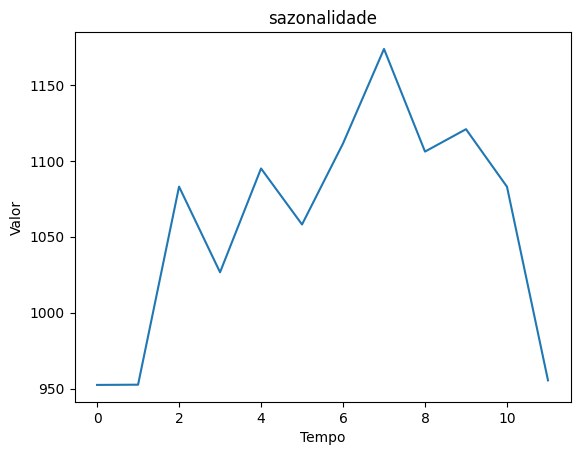

,sazonalidade
sazonalidade,
0,952.414806
1,952.566356
2,1082.986259
3,1026.585244
4,1094.946768
5,1058.063445
6,1111.416604
7,1173.675289
8,1106.060954


In [8]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [9]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,São Paulo- custo m2 (R$),São Paulo - IDH Longevidade,São Paulo - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - IDH Educacao,São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,São Paulo - IDH,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,São Paulo - Consumo de Cimento (t)
0,2003-1,12606.426400,0.835043,0.825444,1.249379,836.486933,1254.225718,13.470493,11.219632,87.918957,1.587388,437.972720,0.794676,8.652299e+07,0.314974,1.034903e+09,4.730940e+07,23.895559,9.819129e+08,8.310335,0.812723,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,952.414806,782.111
1,2003-2,12718.304862,0.835425,0.825117,1.114976,836.981236,1268.256958,13.555238,10.140963,82.539126,1.957841,434.363720,0.794957,8.659168e+07,0.317328,1.036092e+09,4.732994e+07,23.901472,9.822666e+08,8.304194,0.812838,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,952.566356,789.891
2,2003-3,12824.573380,0.835806,0.824790,0.946194,837.344257,1270.950707,13.460122,9.537375,80.042714,2.068918,433.350868,0.795239,8.666036e+07,0.319840,1.037280e+09,4.735047e+07,23.907385,9.826203e+08,8.298053,0.812953,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,1082.986259,774.309
3,2003-4,12924.495880,0.836188,0.824463,0.857395,837.859987,1261.707476,13.181964,8.663709,77.171627,2.177406,431.825332,0.795521,8.672905e+07,0.322104,1.038469e+09,4.737101e+07,23.913298,9.829741e+08,8.291912,0.813068,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,1026.585244,782.071
4,2003-5,13031.542087,0.836570,0.824137,0.688185,838.094744,1264.729439,12.670356,7.872689,75.721222,2.092594,433.287298,0.795802,8.679773e+07,0.324320,1.039658e+09,4.739155e+07,23.919210,9.833278e+08,8.285771,0.813183,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,1094.946768,841.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,39560.290067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1094.946768,NaN
245,2023-6,39516.207562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1058.063445,NaN
246,2023-7,39457.198332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1111.416604,NaN
247,2023-8,39382.246174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1173.675289,NaN


In [10]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      656.269
1      745.154
2      788.618
3      790.169
4      791.663
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: São Paulo - Consumo de Cimento (t), Length: 249, dtype: float64

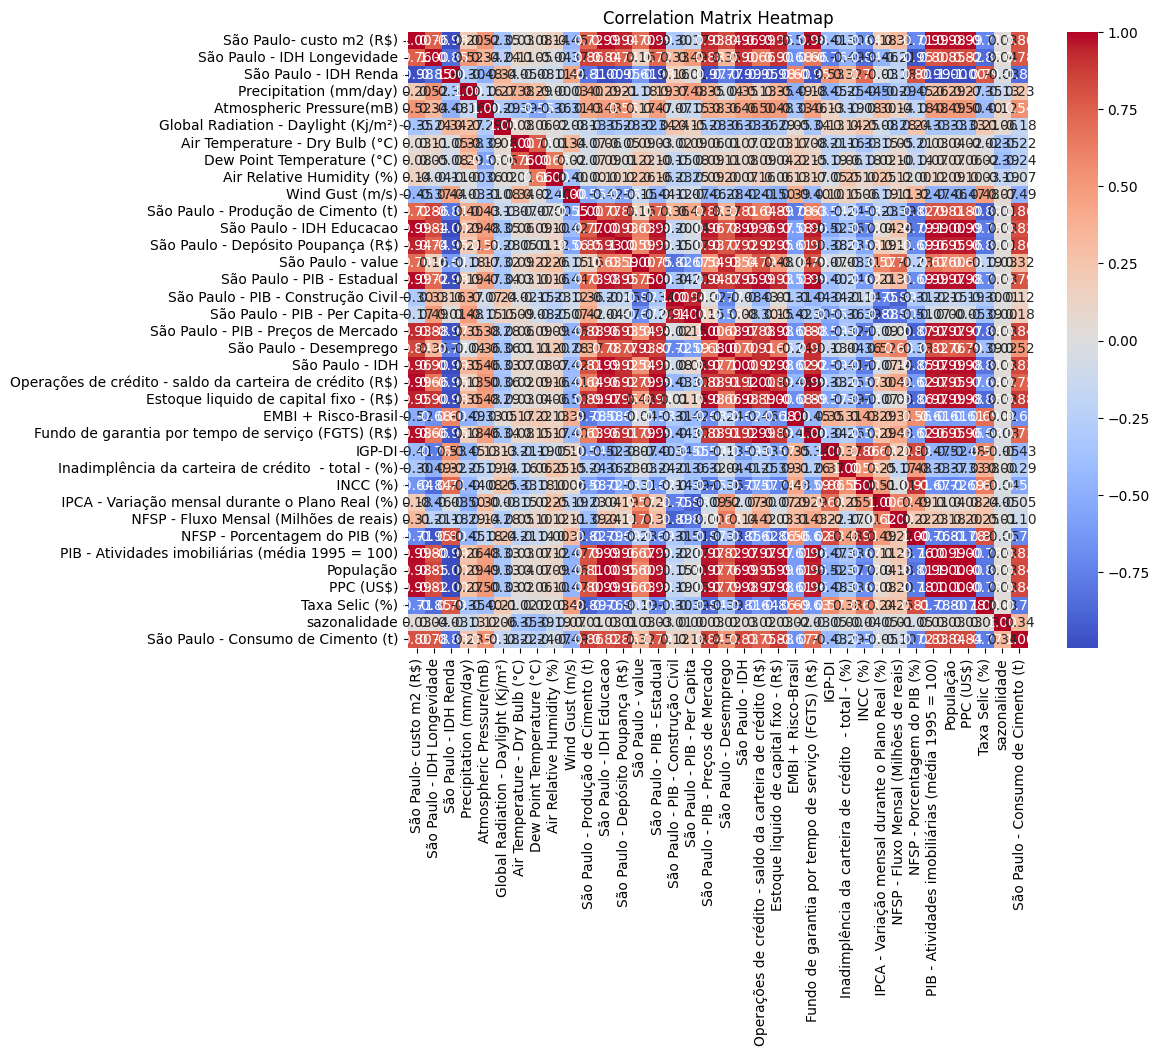

In [11]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [13]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,São Paulo- custo m2 (R$),2.393633e+05
1,São Paulo - IDH Longevidade,2.200545e+05
2,São Paulo - IDH Renda,2.326973e+08
3,Precipitation (mm/day),9.085293e+00
4,Atmospheric Pressure(mB),2.542030e+01
5,Global Radiation - Daylight (Kj/m²),5.795866e+00
6,Air Temperature - Dry Bulb (°C),1.717932e+03
7,Dew Point Temperature (°C),3.079404e+03
8,Air Relative Humidity (%),1.553522e+03
9,Wind Gust (m/s),1.425668e+01


In [14]:
data =data.drop(['Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)',
                 'Air Temperature - Dry Bulb (°C)',
                 'Dew Point Temperature (°C)', 
                 'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 5


,São Paulo- custo m2 (R$),São Paulo - IDH Longevidade,São Paulo - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,12606.426400,0.835043,0.825444,1.249379,836.486933,1254.225718,13.470493,11.219632,87.918957,1.587388,437.972720,8.652299e+07,0.314974,1.034903e+09,4.730940e+07,8.310335,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,952.414806
1,12718.304862,0.835425,0.825117,1.114976,836.981236,1268.256958,13.555238,10.140963,82.539126,1.957841,434.363720,8.659168e+07,0.317328,1.036092e+09,4.732994e+07,8.304194,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,952.566356
2,12824.573380,0.835806,0.824790,0.946194,837.344257,1270.950707,13.460122,9.537375,80.042714,2.068918,433.350868,8.666036e+07,0.319840,1.037280e+09,4.735047e+07,8.298053,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,1082.986259
3,12924.495880,0.836188,0.824463,0.857395,837.859987,1261.707476,13.181964,8.663709,77.171627,2.177406,431.825332,8.672905e+07,0.322104,1.038469e+09,4.737101e+07,8.291912,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,1026.585244
4,13031.542087,0.836570,0.824137,0.688185,838.094744,1264.729439,12.670356,7.872689,75.721222,2.092594,433.287298,8.679773e+07,0.324320,1.039658e+09,4.739155e+07,8.285771,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,1094.946768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,25064.379701,0.854512,0.788671,1.337487,837.344714,1094.702115,15.220491,11.629218,82.219593,2.162021,578.406590,1.392674e+08,0.393494,1.210356e+09,4.666961e+07,11.870791,3.143856e+06,7.824899e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,390.589413,1.078474,1173.675289
152,25163.994084,0.855207,0.787930,1.522577,836.858527,1125.041724,16.115909,12.885244,83.544995,2.745011,570.890194,1.383716e+08,0.392268,1.210849e+09,4.663764e+07,11.871526,3.159665e+06,7.823710e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,391.798431,0.962516,1106.060954
153,25264.756569,0.855903,0.787189,1.584062,836.423789,1154.336388,16.664847,13.899667,85.094546,2.937660,563.909683,1.374758e+08,0.390751,1.211342e+09,4.660568e+07,11.872261,3.177292e+06,7.822521e+06,356.198303,9.630300e+06,0.447600,3.254167,0.489071,0.522000,-1243.715598,2.307250,192.810678,393.032398,1.138989,1120.816122
154,25369.646331,0.856598,0.786449,1.569029,836.192734,1123.650072,17.043098,14.788972,86.765266,2.720670,556.101488,1.365800e+08,0.390185,1.211834e+09,4.657371e+07,11.872996,3.192250e+06,7.821333e+06,363.318059,1.020613e+07,0.426394,3.330340,0.486059,0.509714,-1329.246736,2.242645,192.715004,394.326420,1.038436,1082.913658


In [15]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,São Paulo - IDH Longevidade,São Paulo - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-2.800798,1.936685,-0.265067,0.259587,0.650404,-1.365153,-0.179786,1.201527,-0.189246,-1.719291,-1.294474,-1.070623,-1.580306,-1.073570,-0.583498,-1.219223,-2.123742,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617
1,-2.727632,1.905908,-0.709268,0.616030,0.790142,-1.294003,-0.831288,0.213922,0.406471,-1.750778,-1.291882,-0.986344,-1.559079,-1.040306,-0.587710,-1.218580,-2.088916,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013
2,-2.654466,1.875131,-1.267094,0.877805,0.816970,-1.373860,-1.195847,-0.244358,0.585091,-1.759615,-1.289290,-0.896404,-1.537853,-1.007042,-0.591923,-1.218537,-2.054090,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457
3,-2.581299,1.844355,-1.560577,1.249700,0.724915,-1.607394,-1.723530,-0.771419,0.759550,-1.772925,-1.286698,-0.815323,-1.516627,-0.973779,-0.596135,-1.218044,-2.019264,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128
4,-2.508133,1.813578,-2.119818,1.418983,0.755011,-2.036927,-2.201296,-1.037678,0.623165,-1.760170,-1.284106,-0.735995,-1.495400,-0.940515,-0.600348,-1.216487,-1.984438,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0.930389,-1.526194,0.026133,0.878135,-0.938307,0.104100,0.067599,0.155263,0.734809,-0.494040,0.695958,1.740846,1.552555,-2.109883,1.858748,1.823582,0.951535,0.414233,1.659621,-0.661498,-0.418507,-1.258759,0.318154,2.562832,-0.538499,1.326731,1.398025,0.209123
152,1.063663,-1.595942,0.637856,0.527544,-0.636152,0.855869,0.826223,0.398575,1.672303,-0.559619,0.662153,1.696940,1.561350,-2.161657,1.859252,1.841017,0.944143,0.494098,1.654471,-0.630482,-0.159821,-1.388696,0.293838,2.549126,-0.570093,1.329342,1.415152,-0.182135
153,1.196937,-1.665690,0.841066,0.214053,-0.344403,1.316744,1.438921,0.683034,1.982097,-0.620522,0.628348,1.642604,1.570144,-2.213431,1.859757,1.860456,0.936751,0.584174,1.868895,-0.850517,0.107226,-1.390613,0.251845,2.465341,-0.604269,1.331953,1.432633,0.413308
154,1.330211,-1.735438,0.791382,0.047439,-0.650011,1.634313,1.976049,0.989737,1.633161,-0.688646,0.594543,1.622358,1.578939,-2.265205,1.860261,1.876950,0.929358,0.646687,2.106951,-1.018234,0.372672,-1.421626,0.100243,2.430308,-0.636606,1.327515,1.450965,0.074029


In [16]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,São Paulo - IDH Longevidade,São Paulo - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-2.800798,1.936685,-0.265067,0.259587,0.650404,-1.365153,-0.179786,1.201527,-0.189246,-1.719291,-1.294474,-1.070623,-1.580306,-1.073570,-0.583498,-1.219223,-2.123742,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617
1,-2.727632,1.905908,-0.709268,0.616030,0.790142,-1.294003,-0.831288,0.213922,0.406471,-1.750778,-1.291882,-0.986344,-1.559079,-1.040306,-0.587710,-1.218580,-2.088916,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013
2,-2.654466,1.875131,-1.267094,0.877805,0.816970,-1.373860,-1.195847,-0.244358,0.585091,-1.759615,-1.289290,-0.896404,-1.537853,-1.007042,-0.591923,-1.218537,-2.054090,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457
3,-2.581299,1.844355,-1.560577,1.249700,0.724915,-1.607394,-1.723530,-0.771419,0.759550,-1.772925,-1.286698,-0.815323,-1.516627,-0.973779,-0.596135,-1.218044,-2.019264,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128
4,-2.508133,1.813578,-2.119818,1.418983,0.755011,-2.036927,-2.201296,-1.037678,0.623165,-1.760170,-1.284106,-0.735995,-1.495400,-0.940515,-0.600348,-1.216487,-1.984438,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.153221,-1.058651,-1.135509,1.012807,0.015630,-0.563555,-1.169570,-0.872284,-0.119560,0.367439,1.206136,1.984073,1.423421,-1.436339,1.726650,1.517172,1.018624,-0.364905,1.409149,0.519146,-0.961354,-0.690123,1.744343,1.792831,-0.357756,1.345611,1.245801,-0.282621
140,0.122072,-1.054513,-0.831261,0.631859,0.601744,0.102996,-0.580910,-0.729802,-0.084492,0.290271,1.151427,1.989890,1.436936,-1.498564,1.752364,1.549848,1.015555,-0.347187,1.422197,0.540645,-1.047598,-0.646253,1.739673,1.807843,-0.353467,1.346023,1.254608,-0.612121
141,0.090922,-1.050374,-0.500762,0.506585,1.028982,0.747110,-0.006042,-0.590960,-0.235612,0.211980,1.096718,1.986120,1.450450,-1.560789,1.778078,1.588878,1.012487,-0.321619,1.608476,0.589758,-1.189483,-0.641003,1.698689,1.374436,-0.355172,1.346436,1.263636,-0.137902
142,0.059772,-1.046236,-0.146031,0.218996,0.678015,1.191803,0.682275,-0.122626,-0.438587,0.132345,1.042010,1.973439,1.463965,-1.623013,1.803791,1.625721,1.009418,-0.287493,1.830253,0.536404,-1.332682,-0.650191,1.675167,1.652790,-0.359681,1.337260,1.272935,-0.332143


In [17]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      656.269000
1      745.154000
2      788.618000
3      790.169000
4      791.663000
          ...    
139    998.303416
140    949.776227
141    955.397772
142    928.954121
143    822.219500
Name: São Paulo - Consumo de Cimento (t), Length: 144, dtype: float64

In [18]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [19]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 28)

In [20]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,São Paulo - IDH Longevidade,São Paulo - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
108,0.776263,-0.732916,1.189718,-0.418438,0.443173,0.677698,0.818448,0.509719,-1.004186,1.239301,0.827827,-0.044042,0.773418,0.433505,0.615621,0.595959,0.890825,-0.758140,0.735654,-0.150121,1.452528,-0.134638,-0.348558,-1.286705,-0.712725,0.693264,0.812014,-1.082183
109,0.763896,-0.769313,0.752265,-0.085383,0.173629,0.325740,0.604316,0.551403,-0.789986,1.283160,0.882392,-0.011807,0.799471,0.382807,0.660441,0.621380,0.900214,-0.744935,0.632719,-0.064049,1.577437,-0.250541,-0.314756,-1.091776,-0.707406,0.732176,0.831569,-1.036767
110,0.751529,-0.805709,0.411423,0.189165,-0.915687,-0.251985,0.337397,0.737808,-0.567124,1.309783,0.936956,0.043531,0.825524,0.332108,0.705260,0.652999,0.909602,-0.743509,0.633437,0.165323,1.665230,-0.253852,-0.193331,-1.072106,-0.699231,0.771088,0.850791,-0.752482
111,0.739162,-0.842106,0.477772,0.497136,-1.564261,-0.964857,-0.226241,0.650013,-0.360917,1.316028,0.991520,0.090699,0.851578,0.281409,0.750080,0.685630,0.918990,-0.748471,0.610450,0.155491,1.735648,-0.175858,-0.069191,-1.161345,-0.693507,0.810000,0.868783,-1.088413
112,0.726796,-0.878502,-0.322263,1.127032,-1.385604,-1.619357,-0.884147,0.377736,-0.162773,1.334200,1.046085,0.130391,0.877631,0.230710,0.794899,0.717515,0.928378,-0.764308,0.631167,-0.075593,1.739412,0.099226,-0.104407,-0.961650,-0.679000,0.850727,0.886720,-1.508135
113,0.714429,-0.914899,-0.422625,1.356994,-0.922847,-1.587455,-1.138866,0.014558,-0.068602,1.339236,1.100649,0.177191,0.903684,0.180012,0.839719,0.747579,0.937766,-0.786416,0.659533,-0.323610,1.747279,-0.153882,-0.083975,-0.938217,-0.662783,0.891455,0.905151,-1.474280
114,0.702062,-0.951295,-0.032884,1.339504,0.186911,-1.275940,-1.208542,-0.379106,0.002616,1.361631,1.155213,0.222505,0.929738,0.129313,0.884539,0.775262,0.947155,-0.808518,0.667761,-0.525659,1.756575,-0.146871,-0.089130,-0.921820,-0.650682,0.932183,0.923702,-1.463452
115,0.689695,-0.987692,-0.066178,1.017376,0.910825,-0.787158,-0.890312,-0.404781,0.054549,1.359980,1.209778,0.291859,0.955791,0.078614,0.929358,0.805205,0.956543,-0.838953,0.689072,-0.771574,1.787886,-0.265940,-0.124447,-0.813396,-0.648019,0.969967,0.942382,-1.236037
116,0.677328,-1.024088,0.742327,0.393100,1.138673,0.111332,-0.172102,-0.286677,0.085595,1.337753,1.264342,0.370031,0.981844,0.027915,0.974178,0.836796,0.965931,-0.869366,0.684945,-0.995926,1.740250,-0.285762,-0.077195,-0.692727,-0.640313,1.007752,0.960385,-0.935721
117,0.664961,-1.060485,1.442255,-0.071315,0.944356,0.611269,0.472369,0.105416,-0.030212,1.325387,1.318906,0.459148,1.007898,-0.022783,1.018997,0.876422,0.975319,-0.900682,0.852584,-1.066619,1.618503,-0.293773,-0.110139,-0.644199,-0.639749,1.045536,0.977769,-1.241995


In [21]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 28)

In [22]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [23]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(180, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [24]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [25]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3488445519, 3262589169, 1916034860, 3370426715, 3111904646, 1531244957, 4101383936, 2329912101, 3279852899, 2879222431]


Step: 0 ___________________________________________


2023-11-17 11:26:41.608404: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 11:26:41.608613: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 11:26:41.608910: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

val_loss: 9386.234375
winner_seed: 3488445519


Step: 1 ___________________________________________
val_loss: 12074.05859375


Step: 2 ___________________________________________
val_loss: 4123.0478515625
winner_seed: 1916034860


Step: 3 ___________________________________________
val_loss: 2682.906005859375
winner_seed: 3370426715


Step: 4 ___________________________________________
val_loss: 2328.064697265625
winner_seed: 3111904646


Step: 5 ___________________________________________
val_loss: 24106312.0


Step: 6 ___________________________________________
val_loss: 2464.581787109375


Step: 7 ___________________________________________
val_loss: 4554.83984375


Step: 8 ___________________________________________
val_loss: 6951.91064453125


Step: 9 ___________________________________________
val_loss: 7075.14990234375


final_seed: 3111904646


In [26]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 118ms/step - loss: 1007905.4375 - val_loss: 43177.9141
Epoch 2/10000
4/4 [==============================] - 0s 9ms/step - loss: 17197.8672 - val_loss: 60096.4219
Epoch 3/10000
4/4 [==============================] - 0s 9ms/step - loss: 17776.5898 - val_loss: 43683.9258
Epoch 4/10000
4/4 [==============================] - 0s 9ms/step - loss: 18077.9570 - val_loss: 62030.3516
Epoch 5/10000
4/4 [==============================] - 0s 9ms/step - loss: 17123.7969 - val_loss: 113559.8359
Epoch 6/10000
4/4 [==============================] - 0s 10ms/step - loss: 18847.5703 - val_loss: 77232.9219
Epoch 7/10000
4/4 [==============================] - 0s 9ms/step - loss: 17277.7578 - val_loss: 82444.8672
Epoch 8/10000
4/4 [==============================] - 0s 10ms/step - loss: 17063.9844 - val_loss: 108911.8125
Epoch 9/10000
4/4 [==============================] - 0s 11ms/step - loss: 19887.4883 - val_loss: 35282.1523
Epoch 10/10000
4/4 [========

4/4 [==============================] - 0s 9ms/step - loss: 19756.4492 - val_loss: 57370.9062
Epoch 77/10000
4/4 [==============================] - 0s 9ms/step - loss: 16660.5195 - val_loss: 56036.0078
Epoch 78/10000
4/4 [==============================] - 0s 9ms/step - loss: 17280.0879 - val_loss: 57031.9297
Epoch 79/10000
4/4 [==============================] - 0s 10ms/step - loss: 16743.6543 - val_loss: 108088.4766
Epoch 80/10000
4/4 [==============================] - 0s 10ms/step - loss: 18731.1465 - val_loss: 149576.8125
Epoch 81/10000
4/4 [==============================] - 0s 9ms/step - loss: 22710.6055 - val_loss: 70131.4375
Epoch 82/10000
4/4 [==============================] - 0s 11ms/step - loss: 18425.6309 - val_loss: 55850.3164
Epoch 83/10000
4/4 [==============================] - 0s 10ms/step - loss: 17040.6152 - val_loss: 36748.1680
Epoch 84/10000
4/4 [==============================] - 0s 9ms/step - loss: 19695.2012 - val_loss: 75173.6719
Epoch 85/10000
4/4 [=================

4/4 [==============================] - 0s 9ms/step - loss: 19912.8770 - val_loss: 111762.9297
Epoch 152/10000
4/4 [==============================] - 0s 10ms/step - loss: 20841.7559 - val_loss: 35899.3438
Epoch 153/10000
4/4 [==============================] - 0s 10ms/step - loss: 17127.5254 - val_loss: 64611.0156
Epoch 154/10000
4/4 [==============================] - 0s 9ms/step - loss: 16719.6270 - val_loss: 64075.1680
Epoch 155/10000
4/4 [==============================] - 0s 9ms/step - loss: 18405.2656 - val_loss: 24819.7031
Epoch 156/10000
4/4 [==============================] - 0s 9ms/step - loss: 21003.8984 - val_loss: 36636.6914
Epoch 157/10000
4/4 [==============================] - 0s 9ms/step - loss: 18342.5605 - val_loss: 91340.0547
Epoch 158/10000
4/4 [==============================] - 0s 9ms/step - loss: 17436.3184 - val_loss: 100032.9062
Epoch 159/10000
4/4 [==============================] - 0s 8ms/step - loss: 17125.9980 - val_loss: 74070.8438
Epoch 160/10000
4/4 [==========

4/4 [==============================] - 0s 8ms/step - loss: 18734.5977 - val_loss: 127108.6719
Epoch 227/10000
4/4 [==============================] - 0s 8ms/step - loss: 20469.1582 - val_loss: 91530.7969
Epoch 228/10000
4/4 [==============================] - 0s 8ms/step - loss: 16786.2109 - val_loss: 37613.1641
Epoch 229/10000
4/4 [==============================] - 0s 8ms/step - loss: 18112.1172 - val_loss: 89323.6406
Epoch 230/10000
4/4 [==============================] - 0s 8ms/step - loss: 17027.4707 - val_loss: 5668.7388
Epoch 231/10000
4/4 [==============================] - 0s 8ms/step - loss: 27812.7344 - val_loss: 76091.5469
Epoch 232/10000
4/4 [==============================] - 0s 8ms/step - loss: 16948.0078 - val_loss: 95518.9922
Epoch 233/10000
4/4 [==============================] - 0s 8ms/step - loss: 19595.7129 - val_loss: 87638.2344
Epoch 234/10000
4/4 [==============================] - 0s 8ms/step - loss: 18456.9512 - val_loss: 18883.8516
Epoch 235/10000
4/4 [==============

4/4 [==============================] - 0s 8ms/step - loss: 16889.6133 - val_loss: 27404.0156
Epoch 302/10000
4/4 [==============================] - 0s 9ms/step - loss: 20731.3418 - val_loss: 27467.1230
Epoch 303/10000
4/4 [==============================] - 0s 9ms/step - loss: 19042.4961 - val_loss: 53369.1641
Epoch 304/10000
4/4 [==============================] - 0s 8ms/step - loss: 17319.8184 - val_loss: 62897.4922
Epoch 305/10000
4/4 [==============================] - 0s 8ms/step - loss: 16919.2656 - val_loss: 92441.4844
Epoch 306/10000
4/4 [==============================] - 0s 8ms/step - loss: 18290.3848 - val_loss: 24941.9473
Epoch 307/10000
4/4 [==============================] - 0s 9ms/step - loss: 20355.4160 - val_loss: 94407.0625
Epoch 308/10000
4/4 [==============================] - 0s 9ms/step - loss: 18314.7637 - val_loss: 108559.9062
Epoch 309/10000
4/4 [==============================] - 0s 10ms/step - loss: 18987.5527 - val_loss: 123149.2812
Epoch 310/10000
4/4 [===========

4/4 [==============================] - 0s 9ms/step - loss: 16837.1172 - val_loss: 76156.2969
Epoch 377/10000
4/4 [==============================] - 0s 10ms/step - loss: 16693.7129 - val_loss: 109132.1172
Epoch 378/10000
4/4 [==============================] - 0s 10ms/step - loss: 17686.9863 - val_loss: 70933.7500
Epoch 379/10000
4/4 [==============================] - 0s 10ms/step - loss: 16645.3770 - val_loss: 40778.5312
Epoch 380/10000
4/4 [==============================] - 0s 10ms/step - loss: 17665.3633 - val_loss: 15676.2822
Epoch 381/10000
4/4 [==============================] - 0s 10ms/step - loss: 22596.4727 - val_loss: 31544.8301
Epoch 382/10000
4/4 [==============================] - 0s 10ms/step - loss: 19174.6797 - val_loss: 66371.8750
Epoch 383/10000
4/4 [==============================] - 0s 9ms/step - loss: 16880.6680 - val_loss: 56422.2266
Epoch 384/10000
4/4 [==============================] - 0s 9ms/step - loss: 16645.3594 - val_loss: 87254.0781
Epoch 385/10000
4/4 [=======

Epoch 451/10000
4/4 [==============================] - 0s 9ms/step - loss: 22726.5742 - val_loss: 75368.1172
Epoch 452/10000
4/4 [==============================] - 0s 9ms/step - loss: 16862.1445 - val_loss: 64991.3906
Epoch 453/10000
4/4 [==============================] - 0s 9ms/step - loss: 16876.2188 - val_loss: 63305.5078
Epoch 454/10000
4/4 [==============================] - 0s 10ms/step - loss: 17319.8301 - val_loss: 76112.3438
Epoch 455/10000
4/4 [==============================] - 0s 9ms/step - loss: 16830.2715 - val_loss: 51160.3477
Epoch 456/10000
4/4 [==============================] - 0s 9ms/step - loss: 16616.1973 - val_loss: 75819.0781
Epoch 457/10000
4/4 [==============================] - 0s 9ms/step - loss: 18183.9492 - val_loss: 27805.6133
Epoch 458/10000
4/4 [==============================] - 0s 9ms/step - loss: 20815.7656 - val_loss: 13688.7295
Epoch 459/10000
4/4 [==============================] - 0s 9ms/step - loss: 21623.6934 - val_loss: 80079.0781
Epoch 460/10000
4/

Epoch 526/10000
4/4 [==============================] - 0s 9ms/step - loss: 21328.4355 - val_loss: 41143.5703
Epoch 527/10000
4/4 [==============================] - 0s 8ms/step - loss: 19025.9707 - val_loss: 49835.4336
Epoch 528/10000
4/4 [==============================] - 0s 8ms/step - loss: 16730.6055 - val_loss: 64676.3242
Epoch 529/10000
4/4 [==============================] - 0s 9ms/step - loss: 16712.4297 - val_loss: 75507.2344
Epoch 530/10000
4/4 [==============================] - 0s 10ms/step - loss: 17453.4414 - val_loss: 5243.9102
Epoch 531/10000
4/4 [==============================] - 0s 10ms/step - loss: 29845.4746 - val_loss: 132605.3906
Epoch 532/10000
4/4 [==============================] - 0s 11ms/step - loss: 17482.2754 - val_loss: 47305.7344
Epoch 533/10000
4/4 [==============================] - 0s 9ms/step - loss: 16877.0996 - val_loss: 48215.5430
Epoch 534/10000
4/4 [==============================] - 0s 9ms/step - loss: 17166.6133 - val_loss: 73356.3984
Epoch 535/10000


Epoch 601/10000
4/4 [==============================] - 0s 9ms/step - loss: 19456.8477 - val_loss: 53342.4570
Epoch 602/10000
4/4 [==============================] - 0s 10ms/step - loss: 17843.3281 - val_loss: 32428.5273
Epoch 603/10000
4/4 [==============================] - 0s 10ms/step - loss: 19537.0566 - val_loss: 78089.2500
Epoch 604/10000
4/4 [==============================] - 0s 9ms/step - loss: 17506.6016 - val_loss: 52454.0430
Epoch 605/10000
4/4 [==============================] - 0s 9ms/step - loss: 16584.5703 - val_loss: 77012.1953
Epoch 606/10000
4/4 [==============================] - 0s 9ms/step - loss: 16748.2637 - val_loss: 109072.4141
Epoch 607/10000
4/4 [==============================] - 0s 9ms/step - loss: 19130.5430 - val_loss: 94507.4922
Epoch 608/10000
4/4 [==============================] - 0s 9ms/step - loss: 19616.5312 - val_loss: 50652.1992
Epoch 609/10000
4/4 [==============================] - 0s 9ms/step - loss: 16818.0371 - val_loss: 80918.7422
Epoch 610/10000


Epoch 676/10000
4/4 [==============================] - 0s 10ms/step - loss: 17623.4414 - val_loss: 92821.2656
Epoch 677/10000
4/4 [==============================] - 0s 10ms/step - loss: 16909.9395 - val_loss: 80457.2578
Epoch 678/10000
4/4 [==============================] - 0s 9ms/step - loss: 16901.9316 - val_loss: 110687.0000
Epoch 679/10000
4/4 [==============================] - 0s 9ms/step - loss: 19239.1016 - val_loss: 28747.6426
Epoch 680/10000
4/4 [==============================] - 0s 9ms/step - loss: 19444.6094 - val_loss: 63949.8242
Epoch 681/10000
4/4 [==============================] - 0s 9ms/step - loss: 16797.8203 - val_loss: 33968.0547
Epoch 682/10000
4/4 [==============================] - 0s 9ms/step - loss: 17141.4375 - val_loss: 99197.9609
Epoch 683/10000
4/4 [==============================] - 0s 8ms/step - loss: 17187.7520 - val_loss: 41153.0234
Epoch 684/10000
4/4 [==============================] - 0s 9ms/step - loss: 18091.1074 - val_loss: 32149.6738
Epoch 685/10000


Epoch 751/10000
4/4 [==============================] - 0s 8ms/step - loss: 17072.4805 - val_loss: 63064.5703
Epoch 752/10000
4/4 [==============================] - 0s 8ms/step - loss: 16846.4766 - val_loss: 64846.8398
Epoch 753/10000
4/4 [==============================] - 0s 9ms/step - loss: 16850.4570 - val_loss: 75981.2422
Epoch 754/10000
4/4 [==============================] - 0s 9ms/step - loss: 17115.5469 - val_loss: 73896.0547
Epoch 755/10000
4/4 [==============================] - 0s 9ms/step - loss: 16857.4453 - val_loss: 26025.1426
Epoch 756/10000
4/4 [==============================] - 0s 9ms/step - loss: 24379.0176 - val_loss: 32866.0781
Epoch 757/10000
4/4 [==============================] - 0s 9ms/step - loss: 17477.1836 - val_loss: 103000.6641
Epoch 758/10000
4/4 [==============================] - 0s 9ms/step - loss: 19497.0859 - val_loss: 113742.2891
Epoch 759/10000
4/4 [==============================] - 0s 9ms/step - loss: 20096.9062 - val_loss: 123046.6562
Epoch 760/10000


Epoch 826/10000
4/4 [==============================] - 0s 10ms/step - loss: 21019.9434 - val_loss: 95092.7656
Epoch 827/10000
4/4 [==============================] - 0s 10ms/step - loss: 17965.4570 - val_loss: 35586.5430
Epoch 828/10000
4/4 [==============================] - 0s 9ms/step - loss: 18640.4434 - val_loss: 135749.8125
Epoch 829/10000
4/4 [==============================] - 0s 9ms/step - loss: 21326.6426 - val_loss: 48533.1836
Epoch 830/10000
4/4 [==============================] - 0s 10ms/step - loss: 18056.3691 - val_loss: 160367.0625
Epoch 831/10000
4/4 [==============================] - 0s 10ms/step - loss: 23342.6895 - val_loss: 42380.1953
Epoch 832/10000
4/4 [==============================] - 0s 10ms/step - loss: 18853.6934 - val_loss: 84335.2656
Epoch 833/10000
4/4 [==============================] - 0s 9ms/step - loss: 17311.5254 - val_loss: 12766.8838
Epoch 834/10000
4/4 [==============================] - 0s 9ms/step - loss: 22680.1895 - val_loss: 105410.4531
Epoch 835/1

Epoch 901/10000
4/4 [==============================] - 0s 9ms/step - loss: 17519.6855 - val_loss: 75467.8047
Epoch 902/10000
4/4 [==============================] - 0s 10ms/step - loss: 18218.6035 - val_loss: 76194.5469
Epoch 903/10000
4/4 [==============================] - 0s 9ms/step - loss: 17629.9512 - val_loss: 64798.9180
Epoch 904/10000
4/4 [==============================] - 0s 10ms/step - loss: 16940.7832 - val_loss: 72686.6719
Epoch 905/10000
4/4 [==============================] - 0s 9ms/step - loss: 17490.0234 - val_loss: 88384.2344
Epoch 906/10000
4/4 [==============================] - 0s 10ms/step - loss: 18118.2168 - val_loss: 70054.7578
Epoch 907/10000
4/4 [==============================] - 0s 9ms/step - loss: 17306.7422 - val_loss: 85709.6719
Epoch 908/10000
4/4 [==============================] - 0s 9ms/step - loss: 17536.7500 - val_loss: 37659.6914
Epoch 909/10000
4/4 [==============================] - 0s 10ms/step - loss: 19282.7168 - val_loss: 112661.5000
Epoch 910/1000

Epoch 976/10000
4/4 [==============================] - 0s 10ms/step - loss: 16999.1621 - val_loss: 53497.5000
Epoch 977/10000
4/4 [==============================] - 0s 10ms/step - loss: 16822.9922 - val_loss: 129798.5078
Epoch 978/10000
4/4 [==============================] - 0s 10ms/step - loss: 20657.4805 - val_loss: 70174.3047
Epoch 979/10000
4/4 [==============================] - 0s 9ms/step - loss: 17112.3203 - val_loss: 45627.4336
Epoch 980/10000
4/4 [==============================] - 0s 9ms/step - loss: 17060.4609 - val_loss: 93806.7969
Epoch 981/10000
4/4 [==============================] - 0s 8ms/step - loss: 18383.8516 - val_loss: 57443.4453
Epoch 982/10000
4/4 [==============================] - 0s 9ms/step - loss: 16757.3887 - val_loss: 40190.6445
Epoch 983/10000
4/4 [==============================] - 0s 9ms/step - loss: 18442.5996 - val_loss: 89091.6953
Epoch 984/10000
4/4 [==============================] - 0s 9ms/step - loss: 17450.1445 - val_loss: 117562.0625
Epoch 985/1000

4/4 [==============================] - 0s 9ms/step - loss: 22855.8047 - val_loss: 82679.6562
Epoch 1051/10000
4/4 [==============================] - 0s 8ms/step - loss: 16401.2871 - val_loss: 12693.9717
Epoch 1052/10000
4/4 [==============================] - 0s 8ms/step - loss: 22496.7969 - val_loss: 14642.0010
Epoch 1053/10000
4/4 [==============================] - 0s 9ms/step - loss: 20297.4434 - val_loss: 29318.6074
Epoch 1054/10000
4/4 [==============================] - 0s 9ms/step - loss: 18525.3633 - val_loss: 38922.7227
Epoch 1055/10000
4/4 [==============================] - 0s 9ms/step - loss: 16994.3848 - val_loss: 55058.9453
Epoch 1056/10000
4/4 [==============================] - 0s 10ms/step - loss: 16668.9844 - val_loss: 53601.9141
Epoch 1057/10000
4/4 [==============================] - 0s 9ms/step - loss: 16831.3770 - val_loss: 56424.8828
Epoch 1058/10000
4/4 [==============================] - 0s 9ms/step - loss: 17732.6055 - val_loss: 95888.7109
Epoch 1059/10000
4/4 [====

4/4 [==============================] - 0s 9ms/step - loss: 18980.1699 - val_loss: 88695.3125
Epoch 1125/10000
4/4 [==============================] - 0s 9ms/step - loss: 17686.7559 - val_loss: 98324.5547
Epoch 1126/10000
4/4 [==============================] - 0s 9ms/step - loss: 18108.4961 - val_loss: 29610.1328
Epoch 1127/10000
4/4 [==============================] - 0s 9ms/step - loss: 19319.4414 - val_loss: 114662.3906
Epoch 1128/10000
4/4 [==============================] - 0s 8ms/step - loss: 19367.7598 - val_loss: 85183.2500
Epoch 1129/10000
4/4 [==============================] - 0s 8ms/step - loss: 17257.1699 - val_loss: 165416.8281
Epoch 1130/10000
4/4 [==============================] - 0s 8ms/step - loss: 26730.4844 - val_loss: 38501.0547
Epoch 1131/10000
4/4 [==============================] - 0s 9ms/step - loss: 17247.5469 - val_loss: 45831.8789
Epoch 1132/10000
4/4 [==============================] - 0s 10ms/step - loss: 17329.1504 - val_loss: 80172.3281
Epoch 1133/10000
4/4 [==

4/4 [==============================] - 0s 9ms/step - loss: 18667.8438 - val_loss: 39071.9492
Epoch 1199/10000
4/4 [==============================] - 0s 10ms/step - loss: 18715.0059 - val_loss: 41881.2305
Epoch 1200/10000
4/4 [==============================] - 0s 10ms/step - loss: 16937.0645 - val_loss: 95646.6797
Epoch 1201/10000
4/4 [==============================] - 0s 9ms/step - loss: 17575.8281 - val_loss: 25340.5078
Epoch 1202/10000
4/4 [==============================] - 0s 9ms/step - loss: 18387.5977 - val_loss: 53379.7539
Epoch 1203/10000
4/4 [==============================] - 0s 9ms/step - loss: 16728.6543 - val_loss: 37181.8164
Epoch 1204/10000
4/4 [==============================] - 0s 10ms/step - loss: 17769.6992 - val_loss: 38155.9492
Epoch 1205/10000
4/4 [==============================] - 0s 10ms/step - loss: 17986.5723 - val_loss: 38812.8320
Epoch 1206/10000
4/4 [==============================] - 0s 9ms/step - loss: 17267.8008 - val_loss: 25799.5254
Epoch 1207/10000
4/4 [=

4/4 [==============================] - 0s 9ms/step - loss: 16923.7422 - val_loss: 56745.4453
Epoch 1273/10000
4/4 [==============================] - 0s 11ms/step - loss: 16769.6016 - val_loss: 54761.6758
Epoch 1274/10000
4/4 [==============================] - 0s 10ms/step - loss: 16846.1270 - val_loss: 126880.1875
Epoch 1275/10000
4/4 [==============================] - 0s 9ms/step - loss: 21259.9570 - val_loss: 86241.1953
Epoch 1276/10000
4/4 [==============================] - 0s 9ms/step - loss: 17177.1016 - val_loss: 110543.7812
Epoch 1277/10000
4/4 [==============================] - 0s 10ms/step - loss: 18826.9883 - val_loss: 51384.5391
Epoch 1278/10000
4/4 [==============================] - 0s 10ms/step - loss: 16617.1777 - val_loss: 82984.1172
Epoch 1279/10000
4/4 [==============================] - 0s 9ms/step - loss: 17097.1055 - val_loss: 66200.8438
Epoch 1280/10000
4/4 [==============================] - 0s 9ms/step - loss: 16954.4941 - val_loss: 127623.7812
Epoch 1281/10000
4/4

4/4 [==============================] - 0s 9ms/step - loss: 18139.8379 - val_loss: 40250.5117
Epoch 1347/10000
4/4 [==============================] - 0s 10ms/step - loss: 19369.0312 - val_loss: 75931.5547
Epoch 1348/10000
4/4 [==============================] - 0s 9ms/step - loss: 18141.0527 - val_loss: 15804.4365
Epoch 1349/10000
4/4 [==============================] - 0s 9ms/step - loss: 20574.0039 - val_loss: 179987.3438
Epoch 1350/10000
4/4 [==============================] - 0s 10ms/step - loss: 25547.8770 - val_loss: 44107.4648
Epoch 1351/10000
4/4 [==============================] - 0s 10ms/step - loss: 17898.1016 - val_loss: 48286.4648
Epoch 1352/10000
4/4 [==============================] - 0s 9ms/step - loss: 17015.2070 - val_loss: 50119.8125
Epoch 1353/10000
4/4 [==============================] - 0s 10ms/step - loss: 18466.8730 - val_loss: 106923.5156
Epoch 1354/10000
4/4 [==============================] - 0s 11ms/step - loss: 17076.3867 - val_loss: 56926.7148
Epoch 1355/10000
4/4

4/4 [==============================] - 0s 9ms/step - loss: 23056.2305 - val_loss: 105915.2891
Epoch 1421/10000
4/4 [==============================] - 0s 9ms/step - loss: 18541.7617 - val_loss: 80202.9219
Epoch 1422/10000
4/4 [==============================] - 0s 9ms/step - loss: 16918.7754 - val_loss: 55247.1719
Epoch 1423/10000
4/4 [==============================] - 0s 9ms/step - loss: 17039.9219 - val_loss: 54678.5586
Epoch 1424/10000
4/4 [==============================] - 0s 9ms/step - loss: 17987.5684 - val_loss: 52279.3320
Epoch 1425/10000
4/4 [==============================] - 0s 8ms/step - loss: 18167.4902 - val_loss: 45927.8828
Epoch 1426/10000
4/4 [==============================] - 0s 8ms/step - loss: 17137.2969 - val_loss: 53976.3125
Epoch 1427/10000
4/4 [==============================] - 0s 8ms/step - loss: 16610.3730 - val_loss: 98773.7188
Epoch 1428/10000
4/4 [==============================] - 0s 9ms/step - loss: 17918.1445 - val_loss: 49487.7422
Epoch 1429/10000
4/4 [====

4/4 [==============================] - 0s 10ms/step - loss: 16814.8066 - val_loss: 129747.5547
Epoch 1495/10000
4/4 [==============================] - 0s 9ms/step - loss: 20146.7168 - val_loss: 28250.4316
Epoch 1496/10000
4/4 [==============================] - 0s 10ms/step - loss: 21124.1172 - val_loss: 57012.5625
Epoch 1497/10000
4/4 [==============================] - 0s 9ms/step - loss: 16943.8301 - val_loss: 88180.0547
Epoch 1498/10000
4/4 [==============================] - 0s 9ms/step - loss: 25260.1680 - val_loss: 48077.8984
Epoch 1499/10000
4/4 [==============================] - 0s 10ms/step - loss: 16996.8809 - val_loss: 51984.0820
Epoch 1500/10000
4/4 [==============================] - 0s 10ms/step - loss: 17022.7246 - val_loss: 79954.6094
Epoch 1501/10000
4/4 [==============================] - 0s 9ms/step - loss: 17213.7246 - val_loss: 88135.4531
Epoch 1502/10000
4/4 [==============================] - 0s 9ms/step - loss: 17397.1016 - val_loss: 138559.3750
Epoch 1503/10000
4/4 

4/4 [==============================] - 0s 8ms/step - loss: 17159.4531 - val_loss: 110705.3984
Epoch 1569/10000
4/4 [==============================] - 0s 8ms/step - loss: 18694.9883 - val_loss: 103276.9609
Epoch 1570/10000
4/4 [==============================] - 0s 8ms/step - loss: 18214.3262 - val_loss: 17583.9961
Epoch 1571/10000
4/4 [==============================] - 0s 8ms/step - loss: 23517.1699 - val_loss: 26056.5430
Epoch 1572/10000
4/4 [==============================] - 0s 8ms/step - loss: 20526.3574 - val_loss: 49880.2383
Epoch 1573/10000
4/4 [==============================] - 0s 8ms/step - loss: 16985.2363 - val_loss: 77615.7812
Epoch 1574/10000
4/4 [==============================] - 0s 8ms/step - loss: 16743.8203 - val_loss: 75877.4844
Epoch 1575/10000
4/4 [==============================] - 0s 8ms/step - loss: 16925.0430 - val_loss: 59770.2617
Epoch 1576/10000
4/4 [==============================] - 0s 8ms/step - loss: 16951.1797 - val_loss: 24821.1191
Epoch 1577/10000
4/4 [===

4/4 [==============================] - 0s 9ms/step - loss: 23653.6348 - val_loss: 80647.5312
Epoch 1643/10000
4/4 [==============================] - 0s 9ms/step - loss: 16652.3477 - val_loss: 60624.7656
Epoch 1644/10000
4/4 [==============================] - 0s 10ms/step - loss: 17231.4844 - val_loss: 56543.3008
Epoch 1645/10000
4/4 [==============================] - 0s 9ms/step - loss: 17026.8359 - val_loss: 58095.8906
Epoch 1646/10000
4/4 [==============================] - 0s 8ms/step - loss: 17579.2168 - val_loss: 84716.6328
Epoch 1647/10000
4/4 [==============================] - 0s 9ms/step - loss: 16770.2422 - val_loss: 72904.3672
Epoch 1648/10000
4/4 [==============================] - 0s 9ms/step - loss: 16518.7305 - val_loss: 37957.1172
Epoch 1649/10000
4/4 [==============================] - 0s 9ms/step - loss: 18336.9297 - val_loss: 37782.8828
Epoch 1650/10000
4/4 [==============================] - 0s 9ms/step - loss: 19702.7656 - val_loss: 45533.4453
Epoch 1651/10000
4/4 [====

4/4 [==============================] - 0s 9ms/step - loss: 16757.9668 - val_loss: 89353.3203
Epoch 1717/10000
4/4 [==============================] - 0s 9ms/step - loss: 17451.5547 - val_loss: 59969.2305
Epoch 1718/10000
4/4 [==============================] - 0s 10ms/step - loss: 18279.2129 - val_loss: 9207.5029
Epoch 1719/10000
4/4 [==============================] - 0s 11ms/step - loss: 27368.9473 - val_loss: 43469.7734
Epoch 1720/10000
4/4 [==============================] - 0s 10ms/step - loss: 17488.7441 - val_loss: 33673.9180
Epoch 1721/10000
4/4 [==============================] - 0s 9ms/step - loss: 17447.1992 - val_loss: 22363.4648
Epoch 1722/10000
4/4 [==============================] - 0s 9ms/step - loss: 21842.4180 - val_loss: 66385.9219
Epoch 1723/10000
4/4 [==============================] - 0s 9ms/step - loss: 16621.0059 - val_loss: 78842.6875
Epoch 1724/10000
4/4 [==============================] - 0s 9ms/step - loss: 19951.0059 - val_loss: 22132.5254
Epoch 1725/10000
4/4 [===

4/4 [==============================] - 0s 9ms/step - loss: 19474.9355 - val_loss: 16745.0000
Epoch 1791/10000
4/4 [==============================] - 0s 9ms/step - loss: 21715.5430 - val_loss: 93786.6641
Epoch 1792/10000
4/4 [==============================] - 0s 9ms/step - loss: 17509.1484 - val_loss: 72792.3516
Epoch 1793/10000
4/4 [==============================] - 0s 8ms/step - loss: 16965.8008 - val_loss: 69484.1875
Epoch 1794/10000
4/4 [==============================] - 0s 9ms/step - loss: 16751.3691 - val_loss: 59541.9766
Epoch 1795/10000
4/4 [==============================] - 0s 9ms/step - loss: 17715.8145 - val_loss: 47176.3047
Epoch 1796/10000
4/4 [==============================] - 0s 9ms/step - loss: 17300.7930 - val_loss: 45992.7852
Epoch 1797/10000
4/4 [==============================] - 0s 9ms/step - loss: 16661.0078 - val_loss: 50457.2500
Epoch 1798/10000
4/4 [==============================] - 0s 9ms/step - loss: 19092.7520 - val_loss: 68632.6250
Epoch 1799/10000
4/4 [=====

4/4 [==============================] - 0s 10ms/step - loss: 17202.2598 - val_loss: 102107.9141
Epoch 1865/10000
4/4 [==============================] - 0s 11ms/step - loss: 17273.0195 - val_loss: 33654.8359
Epoch 1866/10000
4/4 [==============================] - 0s 9ms/step - loss: 18244.8066 - val_loss: 14363.6201
Epoch 1867/10000
4/4 [==============================] - 0s 10ms/step - loss: 21913.4844 - val_loss: 56753.4922
Epoch 1868/10000
4/4 [==============================] - 0s 9ms/step - loss: 17291.2168 - val_loss: 28855.5293
Epoch 1869/10000
4/4 [==============================] - 0s 10ms/step - loss: 19554.6797 - val_loss: 13757.9404
Epoch 1870/10000
4/4 [==============================] - 0s 8ms/step - loss: 22193.8281 - val_loss: 84309.8516
Epoch 1871/10000
4/4 [==============================] - 0s 8ms/step - loss: 16846.6289 - val_loss: 51892.2422
Epoch 1872/10000
4/4 [==============================] - 0s 8ms/step - loss: 16630.0176 - val_loss: 65284.5234
Epoch 1873/10000
4/4 [

4/4 [==============================] - 0s 9ms/step - loss: 17191.4844 - val_loss: 70613.7578
Epoch 1939/10000
4/4 [==============================] - 0s 9ms/step - loss: 16659.1543 - val_loss: 50026.4688
Epoch 1940/10000
4/4 [==============================] - 0s 9ms/step - loss: 19148.9297 - val_loss: 52496.2969
Epoch 1941/10000
4/4 [==============================] - 0s 10ms/step - loss: 16719.2891 - val_loss: 66228.0469
Epoch 1942/10000
4/4 [==============================] - 0s 9ms/step - loss: 17313.8457 - val_loss: 104011.8984
Epoch 1943/10000
4/4 [==============================] - 0s 9ms/step - loss: 17277.1426 - val_loss: 88347.0078
Epoch 1944/10000
4/4 [==============================] - 0s 10ms/step - loss: 16700.5176 - val_loss: 61419.0547
Epoch 1945/10000
4/4 [==============================] - 0s 10ms/step - loss: 17166.2852 - val_loss: 65007.5938
Epoch 1946/10000
4/4 [==============================] - 0s 10ms/step - loss: 16536.9941 - val_loss: 133818.4062
Epoch 1947/10000
4/4 

4/4 [==============================] - 0s 10ms/step - loss: 16614.4473 - val_loss: 109703.7266
Epoch 2013/10000
4/4 [==============================] - 0s 9ms/step - loss: 18050.9082 - val_loss: 132596.7188
Epoch 2014/10000
4/4 [==============================] - 0s 9ms/step - loss: 21087.9434 - val_loss: 40917.5820
Epoch 2015/10000
4/4 [==============================] - 0s 9ms/step - loss: 17128.1465 - val_loss: 105523.9922
Epoch 2016/10000
4/4 [==============================] - 0s 9ms/step - loss: 20309.6172 - val_loss: 89153.8750
Epoch 2017/10000
4/4 [==============================] - 0s 9ms/step - loss: 17408.1895 - val_loss: 35233.9453
Epoch 2018/10000
4/4 [==============================] - 0s 9ms/step - loss: 17366.9160 - val_loss: 91766.6953
Epoch 2019/10000
4/4 [==============================] - 0s 9ms/step - loss: 18311.4258 - val_loss: 24965.9648
Epoch 2020/10000
4/4 [==============================] - 0s 9ms/step - loss: 19516.2051 - val_loss: 93834.6797
Epoch 2021/10000
4/4 [=

4/4 [==============================] - 0s 9ms/step - loss: 17157.6406 - val_loss: 112729.8984
Epoch 2087/10000
4/4 [==============================] - 0s 10ms/step - loss: 19139.3672 - val_loss: 105556.8281
Epoch 2088/10000
4/4 [==============================] - 0s 9ms/step - loss: 18112.7598 - val_loss: 89732.9062
Epoch 2089/10000
4/4 [==============================] - 0s 9ms/step - loss: 17559.6094 - val_loss: 72039.7266
Epoch 2090/10000
4/4 [==============================] - 0s 9ms/step - loss: 16832.9668 - val_loss: 144920.0156
Epoch 2091/10000
4/4 [==============================] - 0s 9ms/step - loss: 22905.5605 - val_loss: 120985.1641
Epoch 2092/10000
4/4 [==============================] - 0s 8ms/step - loss: 19252.1289 - val_loss: 159644.9062
Epoch 2093/10000
4/4 [==============================] - 0s 8ms/step - loss: 26076.6172 - val_loss: 33852.2109
Epoch 2094/10000
4/4 [==============================] - 0s 8ms/step - loss: 18660.3047 - val_loss: 45449.7227
Epoch 2095/10000
4/4 

4/4 [==============================] - 0s 9ms/step - loss: 18668.9180 - val_loss: 79901.1172
Epoch 2161/10000
4/4 [==============================] - 0s 10ms/step - loss: 17351.6543 - val_loss: 131429.1406
Epoch 2162/10000
4/4 [==============================] - 0s 9ms/step - loss: 20592.7109 - val_loss: 52941.0938
Epoch 2163/10000
4/4 [==============================] - 0s 10ms/step - loss: 16817.1660 - val_loss: 23034.4727
Epoch 2164/10000
4/4 [==============================] - 0s 10ms/step - loss: 18606.6113 - val_loss: 63581.1328
Epoch 2165/10000
4/4 [==============================] - 0s 9ms/step - loss: 16508.8164 - val_loss: 96689.0625
Epoch 2166/10000
4/4 [==============================] - 0s 9ms/step - loss: 18079.0137 - val_loss: 146620.6719
Epoch 2167/10000
4/4 [==============================] - 0s 9ms/step - loss: 21852.9707 - val_loss: 48602.0938
Epoch 2168/10000
4/4 [==============================] - 0s 9ms/step - loss: 17135.9727 - val_loss: 22525.0215
Epoch 2169/10000
4/4 [

4/4 [==============================] - 0s 10ms/step - loss: 17476.5879 - val_loss: 73742.4141
Epoch 2235/10000
4/4 [==============================] - 0s 9ms/step - loss: 17125.9043 - val_loss: 56355.9648
Epoch 2236/10000
4/4 [==============================] - 0s 9ms/step - loss: 17417.3770 - val_loss: 102484.8438
Epoch 2237/10000
4/4 [==============================] - 0s 9ms/step - loss: 18490.9121 - val_loss: 124424.2656
Epoch 2238/10000
4/4 [==============================] - 0s 9ms/step - loss: 19914.5176 - val_loss: 58003.0508
Epoch 2239/10000
4/4 [==============================] - 0s 8ms/step - loss: 18303.0547 - val_loss: 64172.4727
Epoch 2240/10000
4/4 [==============================] - 0s 9ms/step - loss: 18213.5859 - val_loss: 29348.6035
Epoch 2241/10000
4/4 [==============================] - 0s 9ms/step - loss: 19779.6660 - val_loss: 37455.9414
Epoch 2242/10000
4/4 [==============================] - 0s 10ms/step - loss: 16567.8164 - val_loss: 100815.6719
Epoch 2243/10000
4/4 [

4/4 [==============================] - 0s 10ms/step - loss: 17418.8906 - val_loss: 87462.2344
Epoch 2309/10000
4/4 [==============================] - 0s 9ms/step - loss: 17411.4863 - val_loss: 45140.2031
Epoch 2310/10000
4/4 [==============================] - 0s 10ms/step - loss: 17004.6641 - val_loss: 28794.8457
Epoch 2311/10000
4/4 [==============================] - 0s 9ms/step - loss: 19878.0508 - val_loss: 130335.3047
Epoch 2312/10000
4/4 [==============================] - 0s 8ms/step - loss: 24098.6680 - val_loss: 16010.9404
Epoch 2313/10000
4/4 [==============================] - 0s 9ms/step - loss: 21210.3828 - val_loss: 43920.7109
Epoch 2314/10000
4/4 [==============================] - 0s 9ms/step - loss: 17239.7480 - val_loss: 58401.8633
Epoch 2315/10000
4/4 [==============================] - 0s 9ms/step - loss: 16854.9102 - val_loss: 24502.5410
Epoch 2316/10000
4/4 [==============================] - 0s 9ms/step - loss: 17832.0684 - val_loss: 67956.8594
Epoch 2317/10000
4/4 [==

In [27]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [28]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,930.280884,930.280884,930.280884,930.280884,930.280884,930.280884,930.280823,930.280823,930.280823,930.280823,930.280823,930.280762
Target,729.273,757.915,923.634,756.663,872.715,844.988,910.653,937.696,871.611,795.853,804.767,712.733
Error,201.007874,172.365906,6.646912,173.617859,57.565857,85.292908,19.627808,7.415161,58.6698,134.427795,125.513794,217.547791


In [29]:
display(mae)
display(mape)

104.97495

0.136123

In [30]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [31]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-11: |Prediction[[11163.371]] - Target[9918.501]| =  Error: [[1244.8701]]; MAPE:[[0.1255099]]


[array([[1244.8701]], dtype=float32)]

1244.8701

0.1255099